In [1]:
import torch
from PIL import Image
from torchvision import transforms, models
from ModelAnalysis import ModelStatsAggregator, ModelStatAnalyser
from sys import version
import timm
from tqdm import tqdm
import urllib
from PIL import Image
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
version

'3.9.5 (default, Aug 29 2021, 19:01:31) \n[GCC 9.3.0]'

In [2]:
model_dict = {
    'ssd': torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd'),
    'lenet': torch.hub.load('pytorch/vision:v0.10.0', 'googlenet'),
    'yolov5s': torch.hub.load('ultralytics/yolov5', 'yolov5s'),
    'yolov5m': torch.hub.load('ultralytics/yolov5', 'yolov5m'),
    'yolov5l': torch.hub.load('ultralytics/yolov5', 'yolov5l'),
    'yolov5x': torch.hub.load('ultralytics/yolov5', 'yolov5x'),
    'alexnet': models.alexnet(),
    'squeezenet_1_0': models.squeezenet1_1(),
    'squeezenet_1_1': models.squeezenet1_0(),
    'googlenet': models.googlenet(),
    'shufflenet_v2_x0_5': models.shufflenet_v2_x0_5(),
    'shufflenet_v2_x1_0': models.shufflenet_v2_x1_0(),
}

Using cache found in /home/sultan/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /home/sultan/.cache/torch/hub/pytorch_vision_v0.10.0
/home/sultan/CNN_Network_Analysis/.venv/lib/python3.9/site-packages/torchvision/models/googlenet.py:77: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of GoogleNet will be changed in future releases of '
Using cache found in /home/sultan/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2021-8-29 torch 1.9.0+cu102 CUDA:0 (GeForce RTX 2070 SUPER, 7979.1875MB)

Fusing layers... 
Model Summary: 224 layers, 7266973 parameters, 0 gradients
Adding AutoShape... 
Using cache found in /home/sultan/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2021-8-29 torch 1.9.0+cu102 CUDA:0 (G

In [3]:
# prepare sample inputs
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

uris = [
    'http://images.cocodataset.org/val2017/000000397133.jpg'
]
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

inputs = [utils.prepare_input(uri) for uri in uris]
ssd_input_batch = utils.prepare_tensor(inputs)

Using cache found in /home/sultan/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [4]:
stats_dict = ModelStatAnalyser.get_models_stats_dict(model_dict, input_batch, ssd_input_batch) 

In [5]:
model_batch_size = 4
model_list = timm.list_models(exclude_filters=['levit_*'], pretrained=False)
in_shapes = []
for model_batch_idx in tqdm(range(0, len(model_list), model_batch_size)):
    for model_name in model_list[model_batch_idx: model_batch_idx+model_batch_size]:
        model = timm.create_model(model_name, pretrained=False)
        config = resolve_data_config({}, model=model)
        transform = create_transform(**config)

        url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
        urllib.request.urlretrieve(url, filename)
        img = Image.open(filename).convert('RGB')
        tensor = transform(img).unsqueeze(0) # transform and add batch dimension
        in_tensor_shape = tensor.size()
        if in_tensor_shape[2] == 224 and in_tensor_shape[3] == 224:       
            in_shapes.append(in_tensor_shape)
            model_dict = {}
            model_dict[model_name] = model
            try:
                res_stats_dict = ModelStatAnalyser.get_models_stats_dict(model_dict, tensor, ssd_input_batch)
            except Exception as e:
                print(f"Model name {model_name}")
                raise e
            stats_dict = stats_dict | res_stats_dict
            

import pickle
with open('stats_dict.backup', 'wb') as backup:
    pickle.dump(stats_dict, backup)

  0%|          | 0/152 [00:00<?, ?it/s]/home/sultan/CNN_Network_Analysis/.venv/lib/python3.9/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
100%|██████████| 152/152 [07:36<00:00,  3.00s/it]


In [2]:
import pickle
with open('stats_dict.backup', 'rb') as backup:
    stats_dict = pickle.load(backup)

In [3]:
total_networks = len(stats_dict.keys())
networks_with_kernel = {f'{k}': 0 for k in range(1, 12)}
for network, stats in stats_dict.items():
    for kernel_size in networks_with_kernel.keys():
        if kernel_size in stats['kernel']._dict:
            networks_with_kernel[kernel_size] += 1
print(total_networks+12)

431


In [4]:
from numpy import linspace
from math import floor, ceil
longest_network_length = max([len(stats['raw_stats'].keys()) for model, stats in stats_dict.items()])
normalized_model_intermediate_layer_size = {}
for model, stats in stats_dict.items():
    normalized_model_intermediate_layer_size[model] = [0]*longest_network_length
    model_length = len(stats['intermediate_layer_sizes'])
    idx_list, step = linspace(0, longest_network_length, model_length, retstep=True)
    idx_list, step = [floor(idx) for idx in idx_list], ceil(step)
    input_layers = stats['intermediate_layer_sizes'][0:-1]
    output_layers = stats['intermediate_layer_sizes'][1:]
    layer_sizes = zip(input_layers, output_layers)
    for idx in idx_list[:-1]:
        in_layer, out_layer = next(layer_sizes)
        in_layer, out_layer = in_layer[1][-1], out_layer[1][-1]
        interpolated_layers = [floor(layer_size) for layer_size in linspace(in_layer, out_layer, step)]
        for interpolation_idx in range(idx, idx+step):
            normalized_model_intermediate_layer_size[model][interpolation_idx] = interpolated_layers[interpolation_idx-idx] 
    # interpolate ith linspace + linspace step size when length of networks < max length
        

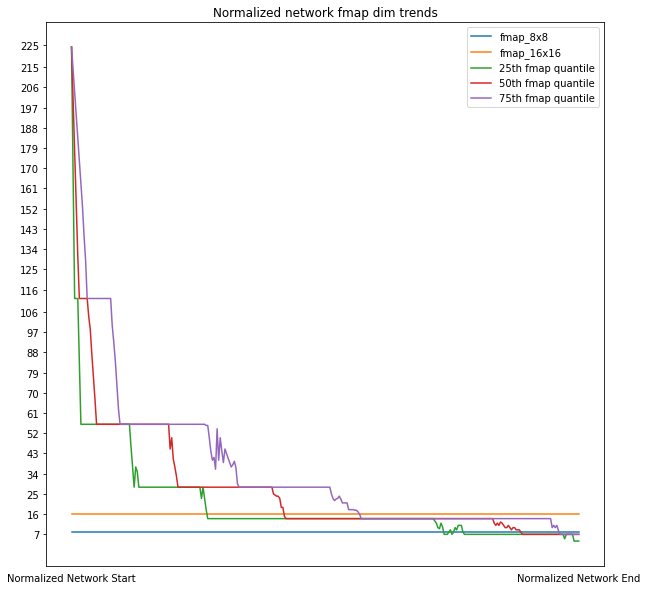

In [5]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [10, 10]
data = [data for model, data in normalized_model_intermediate_layer_size.items() if model != 'ssd']
data = np.array(data)
data_25 = np.quantile(data, axis=0, q=0.25)
data_50 = np.quantile(data, axis=0, q=0.5)
data_75 = np.quantile(data, axis=0, q=0.75)
xtick_labels = ['']*len(data_50)
xtick_labels[0] = 'Normalized Network Start'
xtick_labels[-1] = 'Normalized Network End'
plt.xticks(np.arange(len(data_50)), xtick_labels)
plt.yticks(np.linspace(min(data_50), max(data_50)+1, 25, dtype=int))
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
fmap_8 = [8]*len(data_50)
fmap_16 = [16]*len(data_50)
plt.plot(fmap_8)
plt.plot(fmap_16)
plt.plot(data_25)
plt.plot(data_50)
plt.plot(data_75)
plt.title('Normalized network fmap dim trends')
plt.legend(['fmap_8x8', 'fmap_16x16', '25th fmap quantile', '50th fmap quantile', '75th fmap quantile'])
plt.show()

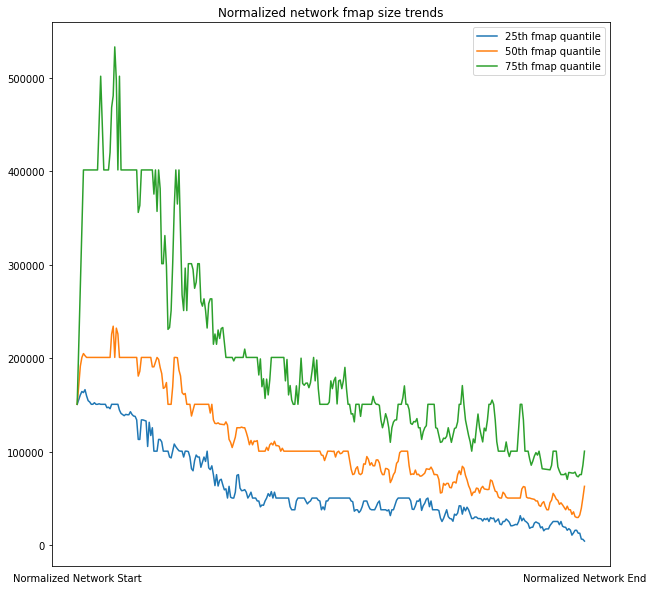

In [29]:
longest_network_length = max([len(stats['raw_stats'].keys()) for model, stats in stats_dict.items()])
normalized_model_intermediate_layer_size = {}
for model, stats in stats_dict.items():
    normalized_model_intermediate_layer_size[model] = [0]*longest_network_length
    model_length = len(stats['intermediate_layer_sizes'])
    idx_list, step = linspace(0, longest_network_length, model_length, retstep=True)
    idx_list, step = [floor(idx) for idx in idx_list], ceil(step)
    input_layers = stats['intermediate_layer_sizes'][0:-1]
    output_layers = stats['intermediate_layer_sizes'][1:]
    layer_sizes = zip(input_layers, output_layers)
    for idx in idx_list[:-1]:
        in_layer, out_layer = next(layer_sizes)
        in_layer, out_layer = in_layer[0], out_layer[0]
        interpolated_layers = [floor(layer_size) for layer_size in linspace(in_layer, out_layer, step)]
        for interpolation_idx in range(idx, idx+step):
            normalized_model_intermediate_layer_size[model][interpolation_idx] = interpolated_layers[interpolation_idx-idx] 
    # interpolate ith linspace + linspace step size when length of networks < max length


data = [data for model, data in normalized_model_intermediate_layer_size.items() if model != 'ssd']
data = np.array(data)
data_25 = np.quantile(data, axis=0, q=0.25)
data_50 = np.quantile(data, axis=0, q=0.5)
data_75 = np.quantile(data, axis=0, q=0.75)
data_100 = np.quantile(data, axis=0, q=1)
xtick_labels = ['']*len(data_50)
xtick_labels[0] = 'Normalized Network Start'
xtick_labels[-1] = 'Normalized Network End'
plt.xticks(np.arange(len(data_50)), xtick_labels)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
plt.plot(data_25)
plt.plot(data_50)
plt.plot(data_75)
# plt.plot(data_100)
plt.title('Normalized network fmap size trends')
plt.legend(['25th fmap quantile', '50th fmap quantile', '75th fmap quantile','100th fmap quantile' ])
plt.show()

In [33]:
longest_network_length = max([len(stats['raw_stats'].keys()) for model, stats in stats_dict.items()])
most_common_kernels_per_fmap_size = {}
for model, stats in stats_dict.items():
    for layer in stats['raw_stats'].values():
        if layer.input_size[-1] not in most_common_kernels_per_fmap_size.keys():
            most_common_kernels_per_fmap_size[layer.input_size[-1]] = {} 
        if layer.kernel_size[0] not in most_common_kernels_per_fmap_size[layer.input_size[-1]].keys():
            most_common_kernels_per_fmap_size[layer.input_size[-1]][layer.kernel_size[0]] = 1
        else:
            most_common_kernels_per_fmap_size[layer.input_size[-1]][layer.kernel_size[0]] += 1

for fmap, ksize_freq in most_common_kernels_per_fmap_size.items():
    ksize_freq = [(k,v) for k, v in sorted(ksize_freq.items(), key=lambda x: x[1], reverse=True)][:3]
    most_common_kernels_per_fmap_size[fmap] = ksize_freq
most_common_kernels_per_fmap_size = {k:v for k, v in most_common_kernels_per_fmap_size.items() if k<=16}
most_common_kernels_per_fmap_size = {k:v for k,v in sorted(most_common_kernels_per_fmap_size.items(), key=lambda x: x[0], reverse=True)}
data = [data for model, data in normalized_model_intermediate_layer_size.items() if model != 'ssd']
data = np.array(data).T
top_3 = [Counter(layer).most_common(3) for layer in data]
top_3 = np.array(top_3)
top_1 = top_3[:, 0, 0]
top_2 = top_3[:, 1, 0]
top_3 = top_3[:, 2, 0]
xtick_labels = ['']*len(top_1)
xtick_labels[0] = 'Normalized Network Start'
xtick_labels[-1] = 'Normalized Network End'


plt.xticks(np.arange(len(top_1)), xtick_labels)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
plt.plot(top_1)
plt.title('Normalized network fmap size trends')
plt.legend(['Top 1 most common kernel'])
plt.show()


plt.xticks(np.arange(len(top_1)), xtick_labels)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
plt.plot(top_2)
plt.title('Normalized network fmap size trends')
plt.legend(['Top 2 most common kernel'])
plt.show()


plt.xticks(np.arange(len(top_1)), xtick_labels)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
plt.plot(top_3)
plt.title('Normalized network fmap size trends')
plt.legend(['Top 3 most common kernel'])
plt.show()

/tmp/ipykernel_6120/2795457497.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  top_3 = np.array(top_3)


IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

In [8]:
# number of networks that dip below fmap_ub^2 in feature map size after 1/2 way through network
max_bound = 16
counts = [0]*len(list(range(1, max_bound)))
for count_idx, fmap_ub in enumerate(range(1, max_bound)):
   for model, data in normalized_model_intermediate_layer_size.items():
       if model != 'ssd':
           second_half_of_network = data[floor(longest_network_length/2):]
           interpolated_layers_with_fmap_lower_than_fmap_ub = list(filter(lambda fmap_size: fmap_size <= fmap_ub, second_half_of_network))
           if len(interpolated_layers_with_fmap_lower_than_fmap_ub) >= 1:
               counts[count_idx] += 1 

counts = [floor(count/total_networks*100) for count in counts] 
# plt.plot(list(range(1, max_bound)), counts)
# plt.show()

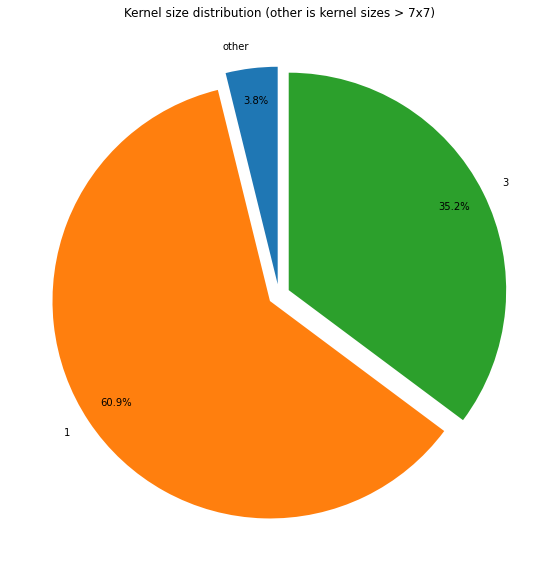

In [9]:
kernel_size_ratios = ModelStatsAggregator.get_aggregate_kernel_stats_as_percentages(stats_dict)

updated_kernel_size_ratios = {}
for kernel, ratio in kernel_size_ratios.items():
    if kernel == '1' or kernel == '3':
        updated_kernel_size_ratios[kernel] = ratio
    else:
        if 'other' not in updated_kernel_size_ratios.keys():
            updated_kernel_size_ratios['other'] = ratio
        else:
            updated_kernel_size_ratios['other'] += ratio
            
kernel_size_ratios = updated_kernel_size_ratios

labels = kernel_size_ratios.keys()
percents = kernel_size_ratios.values()

explode = [0.05]*len(labels)
fig1, ax1 = plt.subplots()
plt.pie(percents, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)
#draw circle
# Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Kernel size distribution (other is kernel sizes > 7x7)')
plt.show()

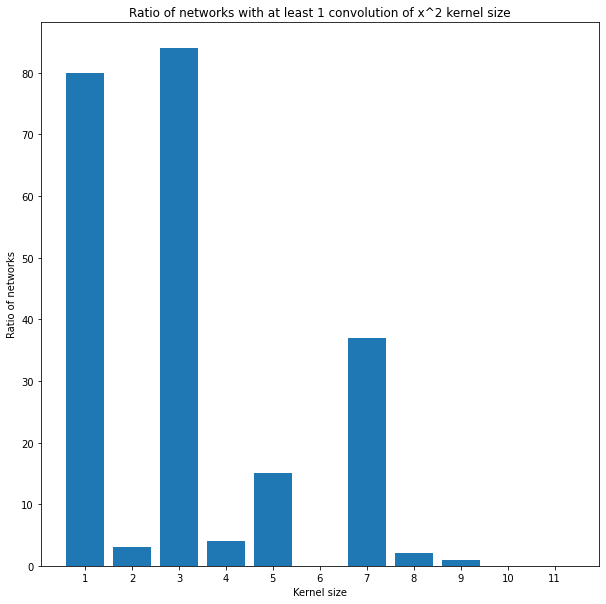

In [10]:
expected_kernel_sizes = list(range(1,12))
count_of_models_with_kernel_size = {f'{k}': 0 for k in expected_kernel_sizes}
for model, stats in stats_dict.items():
    for size in expected_kernel_sizes:
        count_of_models_with_kernel_size[f'{size}'] += (1 if f'{size}' in stats['kernel']._dict.keys() and stats['kernel']._dict[f'{size}'] > 0 else 0)
        
count_of_models_with_kernel_size = {k: floor(v/total_networks*100) for k, v in count_of_models_with_kernel_size.items()}

x = count_of_models_with_kernel_size.keys()
y = count_of_models_with_kernel_size.values()

plt.title('Ratio of networks with at least 1 convolution of x^2 kernel size')
plt.bar(x,y,align='center') # A bar chart
plt.xlabel('Kernel size')
plt.ylabel('Ratio of networks')
plt.show()

In [11]:
normalized_out_in_channel_ratio = {}
for model, stats in stats_dict.items():
    normalized_out_in_channel_ratio[model] = [0]*longest_network_length
    model_length = len(stats['intermediate_layer_sizes'])
    idx_list, step = linspace(0, longest_network_length, model_length, retstep=True)
    idx_list, step = [floor(idx) for idx in idx_list], ceil(step)
    channel_counts = [layer_dim[-3] for layer_size, layer_dim in stats['intermediate_layer_sizes']]
    in_channels = channel_counts[:-1]
    out_channels = channel_counts[1:]
    ratios = [out_channel_count/in_channel_count for out_channel_count, in_channel_count in zip(out_channels, in_channels)]
    layer_sizes = zip(ratios[0:-1], ratios[1:])
    for idx in idx_list[:-2]:
        layer1_ratio, layer2_ratio = next(layer_sizes)
        interpolated_layer_ratios = [layer_size for layer_size in linspace(layer1_ratio, layer2_ratio, step)]
        for interpolation_idx in range(idx, idx+step):
            normalized_out_in_channel_ratio[model][interpolation_idx] = interpolated_layer_ratios[interpolation_idx-idx]
    if len(idx_list) == 2:
        normalized_out_in_channel_ratio[model] = [ratios[0]]*longest_network_length 

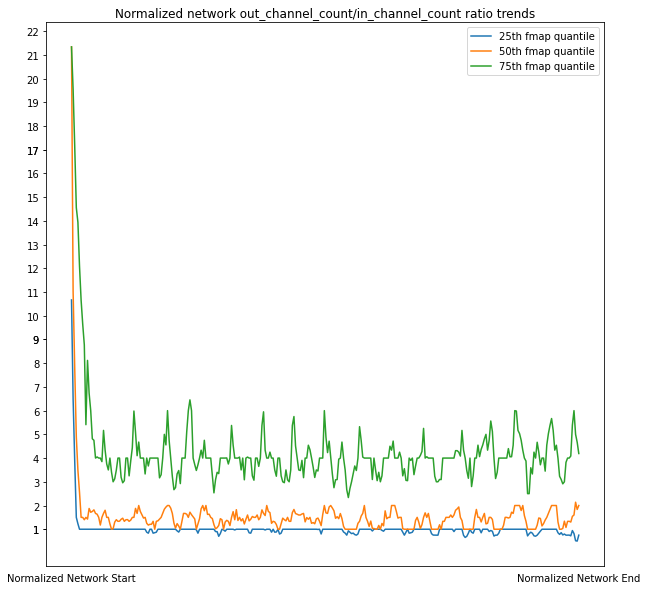

In [12]:
data = [data for model, data in normalized_out_in_channel_ratio.items() if model != 'ssd']
data = np.array(data)
data_25 = np.quantile(data, axis=0, q=0.25)[:-7] # fix zeros near end due to interpolation
data_50 = np.quantile(data, axis=0, q=0.5)[:-7]
data_75 = np.quantile(data, axis=0, q=0.75)[:-7]
xtick_labels = ['']*len(data_50)
xtick_labels[0] = 'Normalized Network Start'
xtick_labels[-1] = 'Normalized Network End'
plt.xticks(np.arange(len(data_50)), xtick_labels)
plt.yticks(np.linspace(min(data_50), max(data_50)+1, 25, dtype=int))
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
plt.plot(data_25)
plt.plot(data_50)
plt.plot(data_75)
plt.title('Normalized network out_channel_count/in_channel_count ratio trends')
plt.legend(['25th fmap quantile', '50th fmap quantile', '75th fmap quantile'])
plt.show()


In [13]:
print(f'25% quantile: {np.quantile(list(normalized_out_in_channel_ratio.values()), 0.25)}')
print(f'50% quantile: {np.quantile(list(normalized_out_in_channel_ratio.values()), 0.50)}')
print(f'75% quantile: {np.quantile(list(normalized_out_in_channel_ratio.values()), 0.75)}')

25% quantile: 1.0
50% quantile: 1.4444444444444442
75% quantile: 4.0
